In [2]:
import copy # copy variables
import os   # manage paths

import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import tqdm # progress bars
from scipy.optimize import curve_fit
import numpy as np

In [3]:
filename = "DAOD_PHYSLITE.37001626._000005.pool.root.1"

In [4]:
for ii in uproot.open(filename).keys():
    print('-',ii)

- ##Params;3
- ##Params;2
- ##Shapes;3
- ##Shapes;2
- ##Links;3
- ##Links;2
- MetaData;1
- MetaDataHdr;1
- MetaDataHdrForm;1
- CollectionTree;1
- POOLContainer;1
- POOLContainerForm;1
- POOLCollectionTree;1


In [5]:
tree = uproot.open({filename: "CollectionTree"})
photons_pt = tree['AnalysisPhotonsAuxDyn.pt'].array()
ph_pt_np = ak.flatten(photons_pt).to_numpy()
print(f'Total number of photons in 8,391 events: {len(ph_pt_np):,}')
ph_pt_np

Total number of photons in 8,391 events: 9,734


array([ 2634.2312,  2475.5974,  1933.7596, ..., 18102.504 , 15249.852 ,
        2147.342 ], dtype=float32)

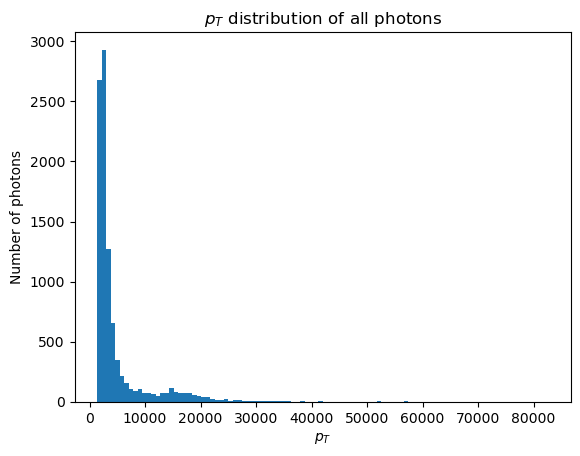

In [6]:
plt.hist(ph_pt_np, bins=100)
plt.title('$p_T$ distribution of all photons')
plt.xlabel('$p_T$')
plt.ylabel('Number of photons')
plt.show()

In [116]:
def exponential(x, a, b):
    return a * np.exp(-b * x)

bins = np.linspace(0, max(ph_pt_np), 1000)
hist, bin_edges = np.histogram(ph_pt_np, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

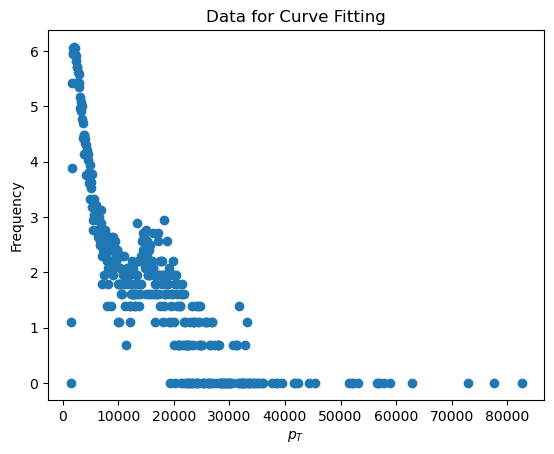

In [107]:
valid_indices = (bin_centers > 0)  # Choose meaningful range
log_hist = np.log(hist[hist > 0])  # Avoid log of zero
log_bins = bin_centers[hist > 0]

plt.scatter(log_bins, log_hist)
plt.xlabel("$p_{T}$")
plt.ylabel("Frequency")
plt.title("Data for Curve Fitting")
plt.show()

In [19]:
from scipy.stats import linregress
slope, intercept, _, _, _ = linregress(log_bins, log_hist)
print(f"Decay rate (b): {-slope}, Amplitude (a): {np.exp(intercept)}")

Decay rate (b): 8.868829176400142e-05, Amplitude (a): 30.07995998933052


In [21]:
# Given amplitude (a) and decay rate (b)
amplitude = np.exp(intercept)  # Replace with your value
decay_rate = -slope  # Replace with your value

# Define the decay function
def decay_function(x):
    return amplitude * np.exp(-decay_rate * x)

In [23]:
x_values = np.linspace(0, max(ph_pt_np), 1000)
y_values = decay_function(x_values)

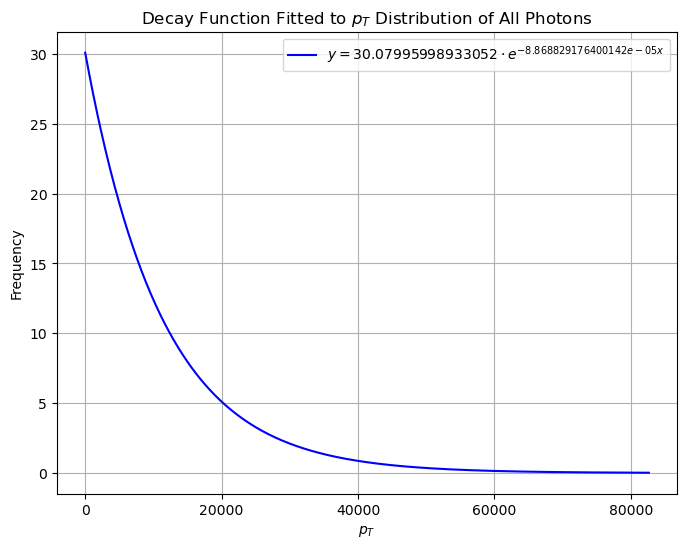

In [109]:
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=f"$y = {amplitude} \cdot e^{{-{decay_rate}x}}$", color="blue")
plt.xlabel("$p_{T}$")
plt.ylabel("Frequency")
plt.title("Decay Function Fitted to $p_T$ Distribution of All Photons")
plt.grid(True)
plt.legend()
plt.show()

## Why low $𝑝_{𝑇}$ is expected for produced photons ##

In particle collisions, such as those at CERN, the incoming particles collide primarily along the beam axis (𝑧-direction).
Transverse momentum ($𝑝_{𝑇}$) represents the momentum component perpendicular to the beam axis.

Many processes produce particles that are primarily aligned with the beam direction, leading to low transverse momenta.
Background radiation, soft processes (like low-energy QCD interactions), and initial-state radiation often dominate at low $𝑝_{𝑇}$.

Direct photons are produced directly in the hard scatter process (e.g., 𝑞𝑔→𝛾𝑞).
These can have a range of $𝑝_{𝑇}$, but softer photons are more common because higher $𝑝_{𝑇}$ photons are less frequent in QCD processes.

Many photons come from the decays of neutral pions ($𝜋_{0}$→𝛾𝛾) or other mesons.
The parent particles often have low momentum, resulting in low $𝑝_{𝑇}$ photons.

## Statistical Evaluation of Fit ##

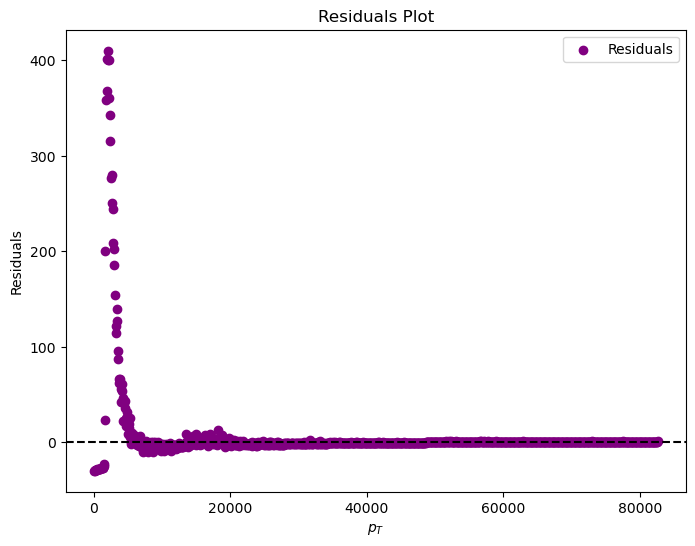

In [111]:
residuals = hist - decay_function(bin_centers)
plt.figure(figsize=(8, 6))
plt.scatter(bin_centers, residuals, color="purple", label="Residuals")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("$p_{T}$")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.show()

In [29]:
mse = np.mean((hist - decay_function(bin_centers))**2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1857.2990317968015


In [31]:
ss_res = np.sum((hist - decay_function(bin_centers))**2)
ss_tot = np.sum((hist - np.mean(hist))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2: {r_squared}")

R^2: 0.12078390242751902


# Analysis of Data for Curve Fitting #

In the scatter plot of data for curve fitting notice there is a second peak at a $𝑝_{𝑇}$ value of around 20000 MeV/c. To analyze this, we will evaluate how the second peak could originate from the decay of massive particles that produce photons with a characteristic $𝑝_{𝑇}$.

### Higgs Boson Decay (𝐻→𝛾𝛾) ###
The Higgs boson, if produced in the collision, decays into two photons. These photons have a characteristic $𝑝_{𝑇}$ distribution depending on the Higgs boson's momentum and decay kinematics. A peak around 20 GeV/c could correspond to photons from a specific decay channel.

### Resonances or Exotic Particles ###
Decay of other resonant particles (e.g., Z boson, new physics candidates like a hypothetical axion-like particle).
The peak could signify a particle with a specific mass being produced and decaying into photons.

We can confirm these possibilities by analyzing the invariant mass distribution of the photon pairs.

In [78]:
photons = ak.zip(
    {
        "pt": tree["AnalysisPhotonsAuxDyn.pt"].array(),
        "eta": tree["AnalysisPhotonsAuxDyn.eta"].array(),
        "phi": tree["AnalysisPhotonsAuxDyn.phi"].array(),
    }
)
photons

<Array [[], ..., [{pt: 1.52e+04, ...}, ...]] type='8391 * var * {pt: float3...'>

In [50]:
def invariant_mass(photon1, photon2):
    # Photon 1 properties
    pt1, eta1, phi1 = photon1['pt'], photon1['eta'], photon1['phi']
    # Photon 2 properties
    pt2, eta2, phi2 = photon2['pt'], photon2['eta'], photon2['phi']
    
    # Energy of each photon (assuming massless)
    E1 = pt1 * np.cosh(eta1)
    E2 = pt2 * np.cosh(eta2)
    
    # Momentum components
    px1, py1, pz1 = pt1 * np.cos(phi1), pt1 * np.sin(phi1), pt1 * np.sinh(eta1)
    px2, py2, pz2 = pt2 * np.cos(phi2), pt2 * np.sin(phi2), pt2 * np.sinh(eta2)
    
    # Total energy and momentum
    E_total = E1 + E2
    px_total = px1 + px2
    py_total = py1 + py2
    pz_total = pz1 + pz2
    
    # Magnitude of total momentum
    p_total_mag = np.sqrt(px_total**2 + py_total**2 + pz_total**2)
    
    # Invariant mass
    invariant_mass = np.sqrt(E_total**2 - p_total_mag**2)
    return invariant_mass

In [88]:
invariant_masses = np.array([])

for photon_group in photons:
    for i in range(len(photon_group)-1):
        if i%2 == 0:
            invariant_masses = np.append(invariant_masses, [invariant_mass(photon_group[i], photon_group[i+1])])

invariant_masses

array([ 4707.0757717 ,  7664.2277638 , 16035.50113158, ...,
        6277.21398376,  5310.85055006,  4863.40445217])

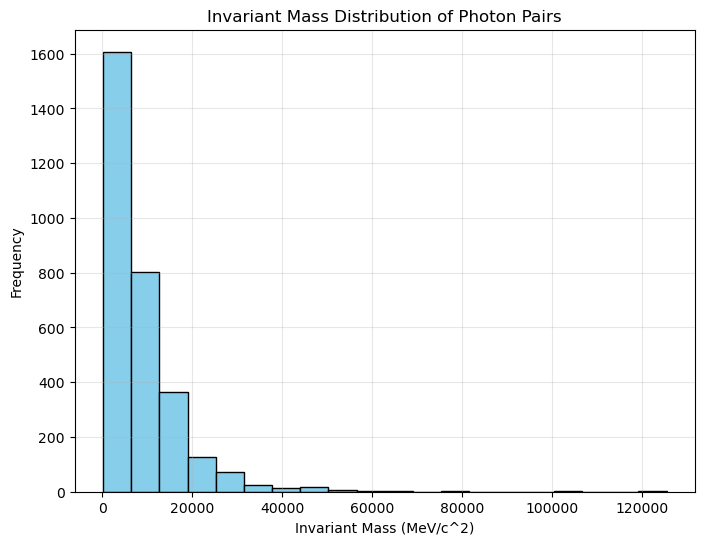

In [90]:
# Plot the invariant mass distribution
plt.figure(figsize=(8, 6))
plt.hist(invariant_masses, bins=20, color='skyblue', edgecolor='black')
plt.title("Invariant Mass Distribution of Photon Pairs")
plt.xlabel("Invariant Mass (MeV/c^2)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

### Invariant Mass Distribution Analysis ###

The plot reveals no obvious peaks at values of around 125 GeV/$c^{2}$, but we can see that there are invariant mass values at that range. This signifies that Higgs boson decay or resonances and exotic particles explains a small amount of the peak in $𝑝_{𝑇}$ at 20000 MeV/c.

The almost insignificant frequency indicates that the main reason for the peak in $𝑝_{𝑇}$ at 20000 MeV/c is most likely not Higgs boson decay or resonances and exotic particles.

### Other Possibilities ###

High-Energy Parton Scattering:
A second peak could arise from a hard scatter process involving high-energy quarks or gluons.
Example: A Compton-like process (𝑞𝑔→𝑞𝛾) or photon radiation from a high-$𝑝_{𝑇}$ quark.

Boosted Photons:
If the parent particle (e.g., a Higgs boson or 𝑍) is produced with a significant boost, the photons emitted could have a characteristic $𝑝_{𝑇}$ much higher than typical background photons.

Pileup Events:
Multiple proton-proton collisions occurring simultaneously (common in high-luminosity experiments). These overlapping events could produce a high-$𝑝_{𝑇}$ photon signature unrelated to a single collision.

This could also indicate a new boson or mediator decaying to photons, dark matter interactions producing photon signatures, or supersymmetry (SUSY) or other extensions predicting photon production at characteristic energies.